In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np 
from PIL import Image

In [26]:
def tensor_to_image(tensor):
    tensor = tensor*255
    tensor = np.array(tensor, dtype = np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    
    return Image.fromarray(tensor)

In [75]:
# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
content_path = '../KakaoTalk_20220128_002945168.jpg'
# style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')
style_path = '../다운로드.jpg'

In [76]:
content_path

'../KakaoTalk_20220128_002945168.jpg'

In [77]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels = 3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    print(shape, scale)
    new_shape = tf.cast(shape*scale, tf.int32)
    
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

In [78]:
def imshow(image, title = None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis = 0)
    
    plt.imshow(image)
    if title:
        plt.title(title)

tf.Tensor([2316. 3088.], shape=(2,), dtype=float32) tf.Tensor(0.1658031, shape=(), dtype=float32)
tf.Tensor([300. 454.], shape=(2,), dtype=float32) tf.Tensor(1.1277533, shape=(), dtype=float32)


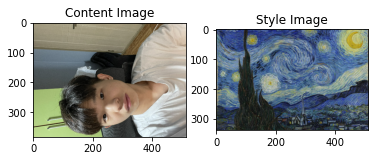

In [79]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1,2, 1)
imshow(content_image, title = 'Content Image')

plt.subplot(1,2, 2)
imshow(style_image, title = 'Style Image')

In [80]:
# 입력 이미지가 주어졌을때, 
# 스타일 전이 알고리즘은 이 중간층들에서 콘텐츠와 스타일에 
# 해당하는 타깃 표현들을 일치시키려고 시도할 것입니다.

In [81]:
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.VGG19(include_top= True, weights = 'imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

TensorShape([1, 1000])

In [82]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_num, prob) for (number, class_num, prob) in predicted_top_5]

[('spatula', 0.056632176),
 ('screwdriver', 0.041894346),
 ('plunger', 0.036402587),
 ('stethoscope', 0.024429254),
 ('paintbrush', 0.024339514)]

In [83]:
vgg = tf.keras.applications.VGG19(include_top= False, weights = 'imagenet')

for layer in vgg.layers:
    print(layer.name)

input_10
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [84]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [85]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top= False, weights='imagenet')
    vgg.trainable = False
    
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

In [86]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  크기: ", output.numpy().shape)
  print("  최솟값: ", output.numpy().min())
  print("  최댓값: ", output.numpy().max())
  print("  평균: ", output.numpy().mean())
  print()

block1_conv1
  크기:  (1, 338, 511, 64)
  최솟값:  0.0
  최댓값:  643.2354
  평균:  22.111395

block2_conv1
  크기:  (1, 169, 255, 128)
  최솟값:  0.0
  최댓값:  2384.6443
  평균:  132.71045

block3_conv1
  크기:  (1, 84, 127, 256)
  최솟값:  0.0
  최댓값:  5926.893
  평균:  127.345

block4_conv1
  크기:  (1, 42, 63, 512)
  최솟값:  0.0
  최댓값:  15371.859
  평균:  480.39017

block5_conv1
  크기:  (1, 21, 31, 512)
  최솟값:  0.0
  최댓값:  3163.2515
  평균:  39.5975



In [87]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [88]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [89]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('스타일:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())
  print()

print("콘텐츠:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    크기: ", output.numpy().shape)
  print("    최솟값: ", output.numpy().min())
  print("    최댓값: ", output.numpy().max())
  print("    평균: ", output.numpy().mean())

스타일:
   block1_conv1
    크기:  (1, 64, 64)
    최솟값:  0.050168056
    최댓값:  23770.209
    평균:  294.55408

   block2_conv1
    크기:  (1, 128, 128)
    최솟값:  0.0
    최댓값:  68522.586
    평균:  9847.708

   block3_conv1
    크기:  (1, 256, 256)
    최솟값:  0.0
    최댓값:  194983.62
    평균:  9534.919

   block4_conv1
    크기:  (1, 512, 512)
    최솟값:  6.0282574
    최댓값:  1889402.4
    평균:  167623.11

   block5_conv1
    크기:  (1, 512, 512)
    최솟값:  0.0
    최댓값:  52143.36
    평균:  1553.5386

콘텐츠:
   block5_conv2
    크기:  (1, 24, 32, 512)
    최솟값:  0.0
    최댓값:  1096.1001
    평균:  15.328037


In [90]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

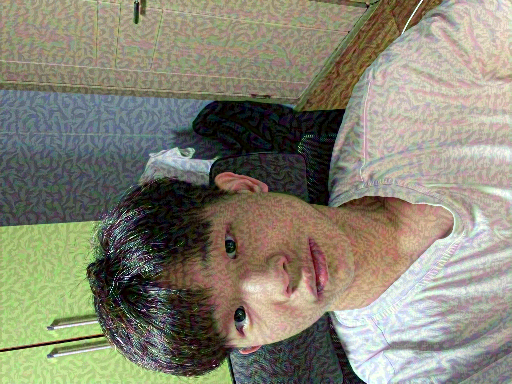

In [91]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

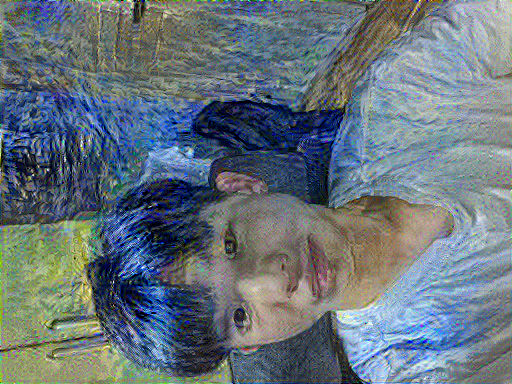

훈련 스텝: 1000


In [92]:
import IPython.display as display
epochs = 10
steps_per_epoch = 100
step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))

In [93]:
total_variation_weight=30
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

image = tf.Variable(content_image)

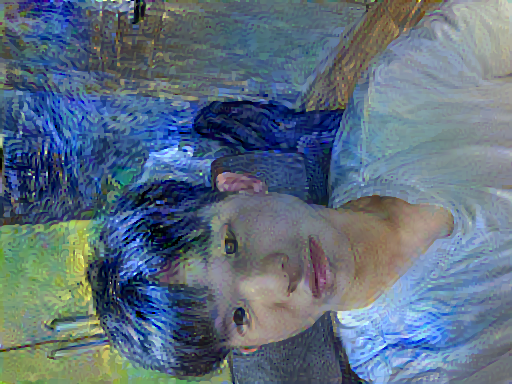

훈련 스텝: 1000


In [94]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("훈련 스텝: {}".format(step))